In [1]:
import pandas as pd; pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
from datetime import datetime
import warnings; warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact, IntSlider
import ipywidgets as widgets
import arrow

#import dmyplant2
from dmyplant2 import (
    cred, MyPlant, Engine, 
    msgFSM, filterFSM, FSMPlot_Start, 
    bokeh_show, dbokeh_chart, add_dbokeh_vlines, get_cycle_data2, 
    disp_result, alarms_pareto, warnings_pareto, states_lines,
    detect_edge_right, detect_edge_left, plot_with_additional_results)
    
cred()
mp = MyPlant(3600)
Engine._list_cached_validations();

In [23]:
def sfun(x):
     return all([ ("920" in str(x['Engine Type'])),  (x['OperationalCondition'] != 'Decommissioned') ])
#fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
#fleet = mp.search_installed_fleet_by_contains_name("920")
fleet = mp.get_installed_fleet()
fleet = fleet.sort_values(by = "Count_OpHour",ascending=False).reset_index(drop='index')
fleet.T

,0,1,2,3,4,5,6,7,8,9,...,29231,29232,29233,29234,29235,29236,29237,29238,29239,29240
Count_OpHour,34210314.0,33620478.0,19726978.0,18284544.0,17956864.0,5153681.0,3735608.0,2597757.0,989889.0,670058.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OperationalCondition,Never Connected,No Contact,No Contact,Never Connected,No Contact,Never Connected,No Contact,No Contact,Never Connected,Never Connected,...,Never Connected,Never Connected,Never Connected,Never Connected,Never Connected,Never Connected,Never Connected,Never Connected,Never Connected,Never Connected
shutdown_counter,NaN,324.0,144.0,NaN,4869.0,NaN,NaN,947.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
startup_counter,NaN,325.0,145.0,NaN,95.0,NaN,NaN,948.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,20724,10899,23690,110857,124710,29756,4885,92973,132667,47942,...,175086,175087,175088,175089,175090,175091,175092,175093,175173,175189
Engine Version,A02,E12,C02,C25,D25,C221,C02,D05,B05,B05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Engine Type,420,620,316,320,312,312,320,312,416,320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Engine Series,4,6,3,3,3,3,3,3,4,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,IT,IT,IT,IT,IT,DE,IT,DE,PK,ES,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BR,NaN,NaN
Commissioning Date,2009-05-31,2010-05-12,2011-09-15,2016-01-14,2018-07-19,2007-12-07,2006-01-01,2015-10-16,NaN,1998-11-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-28,NaN,NaN


In [26]:
fleet['Engine Type'].unique()

array(['420', '620', '316', '320', '312', '416', '216', '612', '212',
       '208', nan, '616', ' ', '412', '156', '106', 'JW 160', ' 320',
       ' 620', '624', '206', '...', '424', ' 416', '920', ' 612', '3',
       'MSY', 'TCR12-41526'], dtype=object)

In [5]:
motor = fleet.iloc[3]
modes = ['???','OFF','MANUAL','AUTO']
success = [True,False]
#success = [True]
motor['IB Site Name'] + ' ' + motor['Engine ID'], modes, success

('BHKW MERHEIM M01', ['???', 'OFF', 'MANUAL', 'AUTO'], [True, False])

In [8]:
e=Engine.from_fleet(mp,motor)
#fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to=datetime.now(), successtime=300)
fsm = msgFSM(e, p_from="2021-10-01", successtime=300)
#fsm = msgFSM(e, p_to='2022-02-01', successtime=600)
#fsm = msgFSM(e, p_from='2022-01-26', p_to='2022-02-01', successtime=600)

#fsm.restore()
fsm.run1(enforce=True) # run Finite State Machine
fsm.store()

FSM: 100%|███████████████████████| 23843/23843 [00:04<00:00, 5030.92 messages/s]


In [9]:
rdf = fsm.starts
rda = rdf[:].reset_index(drop='index')
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))].reset_index(drop='index')
display(HTML(pd.DataFrame.from_dict(e.dash, orient='index').T.to_html(escape=False, index=False)))
#rda[filterFSM.run2filter_content].round(2)
print(f"Starts: {rdf.shape[0]}, Successful: {rdf[rdf['success'] == True].shape[0]}, Failed: {rdf[rdf['success'] == False].shape[0]} => {rdf[rdf['success'] == True].shape[0]/rdf.shape[0]*100.0:3.1f}%")

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Na…

Starts: 166, Successful: 109, Failed: 57 => 65.7%


In [10]:
rda[filterFSM.run2filter_content].round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,0,True,???,60.32,7.49,28.33,,37.85,178.57,312.560999,,,1592.84,122.58,0.0,123.9,0.0,2.0
1,1,False,???,1.62,,,,,,1.617999,,,,,,,0.0,0.0
2,2,True,???,60.38,8.27,23.14,,16.92,178.57,287.282999,,,5956.64,86.44,0.0,124.54,0.0,0.0
3,3,False,???,1.41,,,,,,1.412,,,,,,,0.0,0.0
4,4,True,???,60.43,7.79,23.71,,13.27,178.57,283.771998,,,14888.3,67.52,0.0,124.82,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,161,True,AUTO,40.37,8.16,20.39,,12.62,178.57,260.109998,,,1001.82,261.82,0.0,123.93,1.0,2.0
162,162,False,AUTO,40.57,8.48,20.14,,29.52,146.68,245.384999,,,,301.68,0.0,122.81,0.0,0.0
163,163,False,AUTO,60.44,7.48,21.57,,9.73,178.57,277.783998,,,0.2,300.14,0.0,123.84,1.0,0.0
164,164,False,AUTO,40.88,7.29,21.2,,5.66,178.57,253.609998,,,0.0,130.34,0.0,122.02,0.0,0.0


In [11]:
fsm.results['starts'][0];

In [ ]:
#Execute FSM Run 2
# fsm.restore()
# rda = fsm.run2(rda, silent=False)
# fsm.store()

In [12]:
#rdb = rda[(rda['mode'].isin(['AUTO','MANUAL'])) & ((rda['count_alarms'] > 0) | (rda['count_warnings'] > 0))]
#rdb = rda[rda['synchronize'] < 15.0]
rdb = rda
#rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2)

,startpreparation,speedup,idle,synchronize,loadramp,maxload,ramprate,targetoperation,rampdown,coolrun,runout
count,165.00,120.00,12.00,119.00,117.00,0.0,0.0,114.00,112.00,108.00,103.00
mean,54.23,23.37,157.09,26.87,177.31,NaN,NaN,68020.74,105.12,3425.48,124.19
std,61.84,5.38,101.15,39.32,10.14,NaN,NaN,108634.19,68.98,21273.59,1.15
min,1.31,12.76,8.68,2.03,73.77,NaN,NaN,0.00,0.10,0.00,115.09
25%,4.96,21.62,117.20,10.89,178.57,NaN,NaN,13581.61,68.88,0.00,124.04
50%,60.36,22.27,132.46,19.10,178.57,NaN,NaN,26176.69,95.30,0.00,124.31
75%,60.42,23.66,247.69,25.11,178.57,NaN,NaN,63811.85,123.87,0.00,124.63
max,356.44,73.48,333.41,361.25,178.57,NaN,NaN,622433.28,314.60,167492.46,125.48


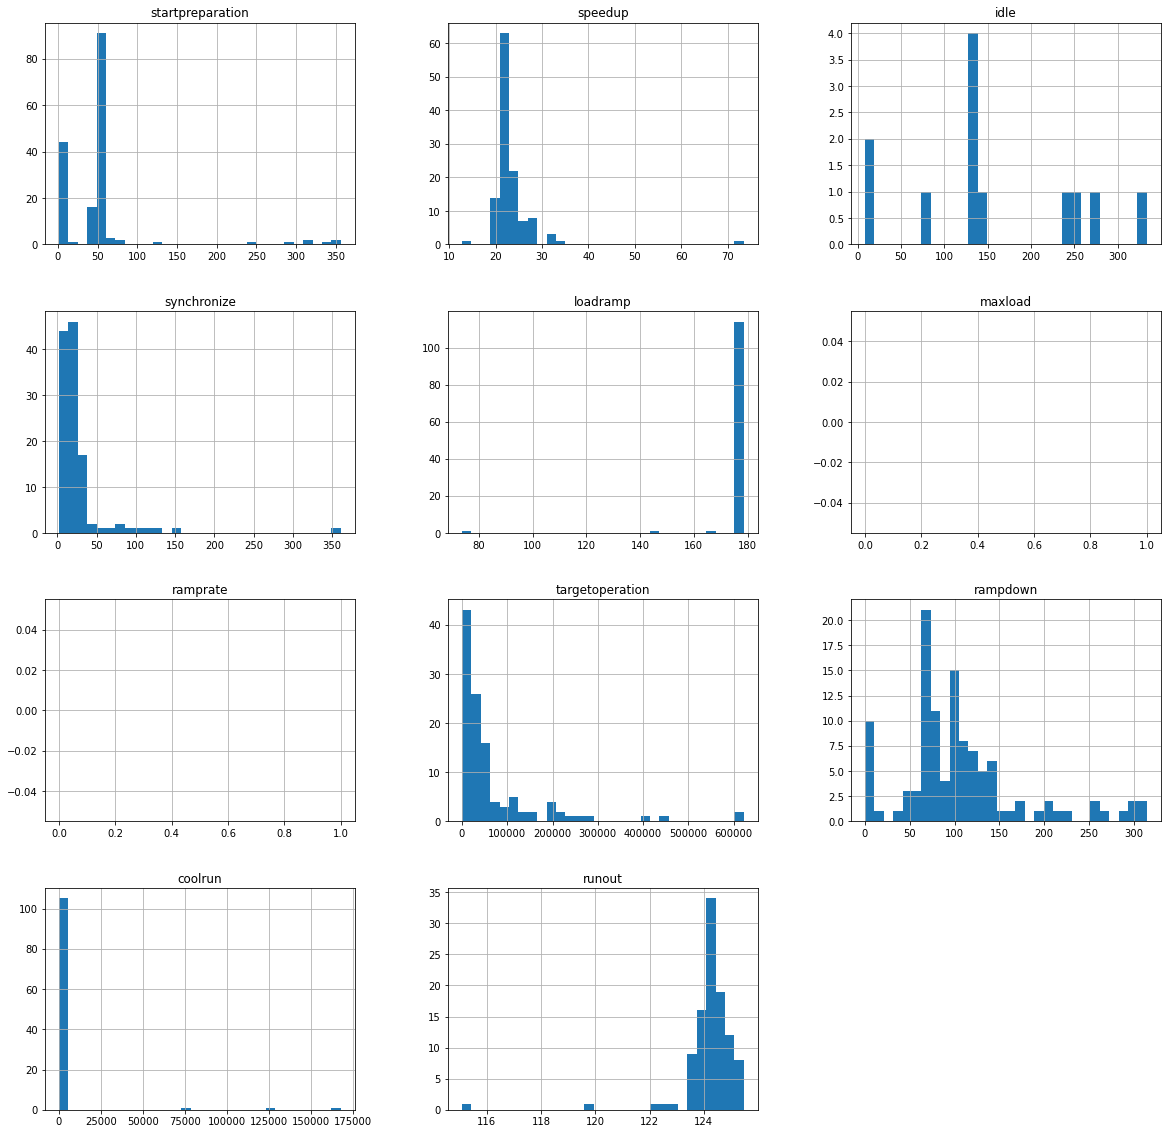

In [13]:
vec = ['startpreparation','speedup','idle','synchronize','loadramp','maxload','ramprate','cumstarttime','targetoperation','rampdown','coolrun','runout']
display(_=rdb[vec].hist(bins=30,figsize=(20,20)))
#ax_list[0][2].set_xlim((0,10))
#display(rdb[vec].hist(bins=30,figsize=(20,20)))
display(rdb[vec].describe().round(2))

In [14]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success'])].copy()
rde['datetime'] = pd.to_datetime(rde['starttime'])
dfigsize = (18,10)
dset = [
    {'col':['cumstarttime'],'ylim':(-400,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-20,300)},
    {'col':['startpreparation'],'ylim':(-600,300)},
    {'col':['hochlauf'],'ylim':(-100,200), 'color':'orange'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,3)},
    {'col':['no'],'ylim':(-100,10000),'color':'black'},
    {'col':['maxload'],'ylim':(500,5000) }
]
ftitle = f"{fsm._e}"
fig = dbokeh_chart(rde, dset, style='both', figsize=dfigsize ,title=ftitle);
bokeh_show(fig)
del(fig)

In [15]:
vset = ['Various_Values_SpeedAct','Power_PowerAct','Exhaust_TempCylMax','Exhaust_TempCylMin','Hyd_PressCrankCase','Hyd_PressOilDif','TecJet_Lambda1','Hyd_PressOil','Hyd_TempOil']
dset = [
    {'col':['Power_PowerAct'], '_ylim':(0,5000), 'color':'red'},
    {'col':['power_diff'], '_ylim':(0,5000), 'color':'purple'},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'},
    {'col':['Exhaust_TempCylMax'],'_ylim': [0, 2500], 'color':'red'},
    {'col':['Exhaust_TempCylMin'],'_ylim': [0, 2500], 'color':'red'},
    {'col':['Hyd_PressCrankCase'],'ylim': [-100, 100], 'color':'orange'},
    {'col':['Hyd_PressOilDif'],'ylim': [0, 2], 'color':'black'},
    {'col':['TecJet_Lambda1'],'_ylim': [0, 2], 'color':'green'},
    {'col':['Hyd_PressOil'],'_ylim': [0, 10], 'color':'brown'},
    {'col':['Hyd_TempOil'],'_ylim': [0, 110], 'color':'#2171b5'}
]


In [16]:
rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2).fillna('');
rdb[filterFSM.run2filter_content]

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,0,True,???,60.324000,7.488999,28.328000,NaN,37.849000,178.571,312.560999,NaN,NaN,1592.840999,122.580999,0.0,123.905000,0.0,2.0
1,1,False,???,1.617999,NaN,NaN,NaN,NaN,NaN,1.617999,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,2,True,???,60.375000,8.274000,23.142999,NaN,16.920000,178.571,287.282999,NaN,NaN,5956.640000,86.442000,0.0,124.535000,0.0,0.0
3,3,False,???,1.412000,NaN,NaN,NaN,NaN,NaN,1.412,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,4,True,???,60.430999,7.787000,23.714000,NaN,13.268999,178.571,283.771998,NaN,NaN,14888.299000,67.520000,0.0,124.816000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,161,True,AUTO,40.365999,8.159000,20.392000,NaN,12.621999,178.571,260.109998,NaN,NaN,1001.824999,261.823000,0.0,123.929999,1.0,2.0
162,162,False,AUTO,40.574000,8.476999,20.140000,NaN,29.516000,146.678,245.384999,NaN,NaN,NaN,301.680000,0.0,122.806999,0.0,0.0
163,163,False,AUTO,60.439000,7.480999,21.566000,NaN,9.726999,178.571,277.783998,NaN,NaN,0.204000,300.145000,0.0,123.840999,1.0,0.0
164,164,False,AUTO,40.884000,7.289999,21.200999,NaN,5.664000,178.571,253.609998,NaN,NaN,0.000000,130.339000,0.0,122.024000,0.0,0.0


In [17]:
def f(x=0):
    global v; v = x; startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
    display(HTML(ftitle));
    disp_result(startversuch)
interact(f, x = IntSlider(0, 0, rdb.shape[0]-1 , 1, layout=widgets.Layout(width='70%')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='70%'), max=165), Output()), _do…

In [20]:
inerestingstarts_pforzheim_m4 = [41,42,54,67,68,69,70]
inerestingstarts_merheim_m1 = [6]

startversuch = rdb.iloc[v]; 
data = get_cycle_data2(fsm, startversuch, max_length=None, min_length=None, cycletime=1, silent=False, p_data=vset)
data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
fig = plot_with_additional_results(fsm,data, startversuch, vset, dset, dfigsize=dfigsize) 
fsm.starts.iloc[v].to_dict()
bokeh_show(fig)

von: 03.10.2021 16:15:11 bis: 03.10.2021 22:55:02


In [ ]:
fsm.starts.iloc[v].to_dict()

In [ ]:
for i, v in enumerate(fsm.runlogdetail(startversuch, statechanges_only=False)):
    print(f"{i:3} {v}")

In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)